In [49]:
import os
import sys

sys.path.append('../')
import h5py
import hdf5storage
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

from kwave.ktransducer import kWaveGrid
from utils.simulations import get_water_SoS

Define the size and resolution of the computational grid.

In [50]:
Nx, Ny = 560, 560
dx, dy = 4.e-5, 4.e-5

center_pos = [0, 0]
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

### Speed of Sound

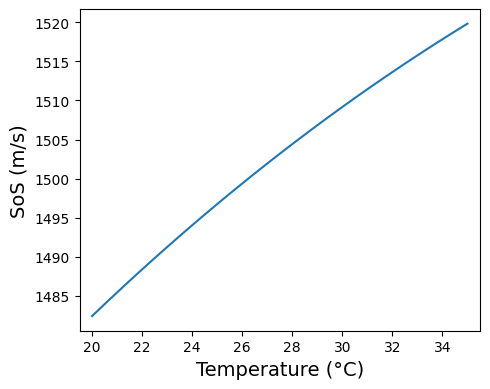

In [51]:
def get_water_SoS(t):
    """Calculate the speed of sound of water at temperature `t` in Celsius."""
    a = [1.402385e3, 5.038813, -5.799136e-2, 3.287156e-4, -1.398845e-6, 2.787860e-9]
    SoS = 0
    for i in range(len(a)):
        SoS += a[i] * t**i
    return SoS

ts = np.linspace(20, 35, 100)
vs = [get_water_SoS(t) for t in ts]
plt.figure(figsize=(5, 4))
plt.plot(ts, vs)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('SoS (m/s)', fontsize=14)
plt.xlim(19.5, 35.5)
plt.tight_layout()

In [52]:
T = 31.0
v0 = get_water_SoS(T)   # SoS of the two circles. [m/s]
structures = {
  'body': (9.8e-3, 1545, (0, 0)),
  'liver': (7.5e-3, 1585.7, (0, 1.7e-3)),
  'vertebral column': (1.4e-3, 2600.0, (0, -7.7e-3)),
  'spinal cord': (1.1e-3, 1542.0, (0, -7.7e-3)),
  'abdominal aorta': (0.8e-3, 1578.2, (0, -5.1e-3)), 
  'stomach lumen': (2.5e-3, 1535.4, (3e-3, -0.5e-3)),
  'intestine lumen': (1.4e-3, 1535.4, (-4e-3, 3e-3)),
}

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
SoS = np.ones((Ny, Nx)) * v0
for key, (R, v, offset) in structures.items():
    SoS[(XX - offset[0])**2 + (YY - offset[1])**2 < R**2] = v

<Figure size 700x700 with 0 Axes>

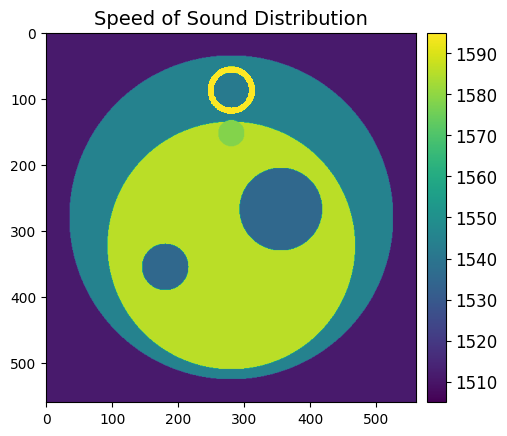

In [53]:
plt.figure(figsize=(7,7))
norm = matplotlib.colors.Normalize(vmax=1595, vmin=1505)
fig, ax = plt.subplots()
plt.title('Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS, norm=norm)
cax = fig.add_axes([ax.get_position().x1+0.017, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=13)
# cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
plt.tick_params(labelsize=12)
plt.show()
# plt.savefig('../figures/SoS.jpg', bbox_inches='tight')

Save the SoS

In [54]:
file_name = os.path.join('../', 'data', 'SoS.mat')
if os.path.exists(file_name):
    os.remove(file_name)
data = {'SoS': SoS.swapaxes(0,1)}
hdf5storage.savemat(file_name, data)

### Initial Pressure

In [55]:
structures = {
  'body': (9.8e-3, 9.65e-3, 0.5, (0, 0)),
  'tissue': (9.65e-3, 0, 0.2, (0, 0)),
  'liver': (7.5e-3, 7.3e-3, 0.5, (0, 1.7e-3)),
  'vertebral column': (1.4e-3, 1.1e-3, 0.8, (0, -7.7e-3)),
  'abdominal aorta': (0.7e-3, 0.0, 0.6, (0, -5.1e-3)), 
  'stomach lumen': (2.5e-3, 2.3e-3, 0.5, (3e-3, -0.5e-3)),
  'intestine lumen': (1.4e-3, 0, 0.5, (-4e-3, 3e-3)),
}

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
IP = np.ones((Ny, Nx)) * 0.
for key, (R_out, R_in, i, offset) in structures.items():
    IP[((XX - offset[0])**2 + (YY - offset[1])**2 < R_out**2) & ((XX - offset[0])**2 + (YY - offset[1])**2 >= R_in ** 2)] = i
    

<Figure size 700x700 with 0 Axes>

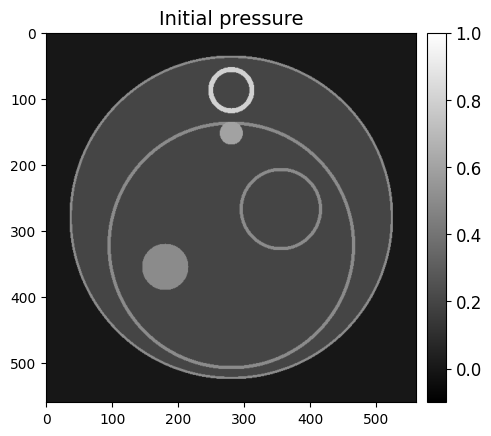

In [56]:
plt.figure(figsize=(7,7))
norm = matplotlib.colors.Normalize(vmax=0, vmin=1)
fig, ax = plt.subplots()
plt.title('Initial pressure', fontsize=14)
plt.imshow(IP, norm=norm, cmap='gray')
cax = fig.add_axes([ax.get_position().x1+0.017, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.tick_params(labelsize=13)
cb.ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.tick_params(labelsize=12)
plt.show()

In [57]:
file_name = os.path.join('../', 'data', 'IP.mat')
if os.path.exists(file_name):
    os.remove(file_name)
data = {'IP': IP.swapaxes(0,1)}
hdf5storage.savemat(file_name, data)